In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import xgboost as xgb
from scipy.stats import randint, uniform
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, median_absolute_error
from sklearn.utils import resample
from sklearn.inspection import PartialDependenceDisplay

In [3]:
# import the data and  drop no longer needed columns
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
0,0,0,6,11,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,20,4,4,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,18,3,10,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,19,0,11,1,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,20,2,10,0,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [4]:
# split into features and target variable
X = video_df.drop(columns="box_view_rate")
y = video_df["box_view_rate"]

# split into training and test data
SEED = 666
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
50,0,11,0,11,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
309,0,19,1,9,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,12,3,5,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
364,0,17,4,4,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
346,0,16,3,1,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
# load fitted lambda and back transform box cox test target values
with open("data/fitted_lambda.pkl", "rb") as f:
    fitted_lambda = pickle.load(f)

y_test_original = inv_boxcox(y_test, fitted_lambda)

In [6]:
# hyperparameter tune a decision tree regressor
params = {"decisiontreeregressor__max_depth": [3, 5, 10, 15, 20, 30, None], "decisiontreeregressor__min_samples_leaf": [2, 4, 6], "decisiontreeregressor__min_samples_split": [2, 5, 10]}
pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.6330058326777248, best params: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 2}


In [7]:
# fit decision tree with optimal parameters
dt = DecisionTreeRegressor(max_depth=best_params["decisiontreeregressor__max_depth"], min_samples_leaf=best_params["decisiontreeregressor__min_samples_leaf"], min_samples_split=best_params["decisiontreeregressor__min_samples_split"], random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_original = inv_boxcox(y_pred, fitted_lambda)
box_rmse = root_mean_squared_error(y_test, y_pred)
original_rmse = root_mean_squared_error(y_test_original, y_pred_original)
medae = median_absolute_error(y_test_original, y_pred_original)
r2 = dt.score(X_test, y_test)
print(f"r2: {round(r2, 2)}, box_rmse: {round(box_rmse, 2)}, original_rmse: {round(original_rmse, 2)}, medae: {round(medae, 2)}")

r2: 0.66, box_rmse: 1.91, original_rmse: 552.01, medae: 17.25


In [8]:
# instantiate random forest and use randomized cross validation to search wide range of hyperparameters
params = {"randomforestregressor__n_estimators": [100, 200, 300, 500, 1000], "randomforestregressor__max_depth": [10, 20, 30, 50, None], "randomforestregressor__min_samples_leaf": [2, 4, 6],
          "randomforestregressor__max_features": ["sqrt", "log2", None], "randomforestregressor__bootstrap": [True, False]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
rand_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=10, n_iter=50, scoring="r2", n_jobs=-1, random_state=SEED)
rand_search.fit(X_train, y_train)
best_params = rand_search.best_params_
print(f"best score: {rand_search.best_score_}, best params: {best_params}")

best score: 0.7390931043435903, best params: {'randomforestregressor__n_estimators': 1000, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': 10, 'randomforestregressor__bootstrap': True}


In [9]:
# use gridsearch for fine-tuning hyperparameters
params = {"randomforestregressor__n_estimators": np.arange(best_params["randomforestregressor__n_estimators"] - 20, best_params["randomforestregressor__n_estimators"] + 30, 10), "randomforestregressor__max_depth": [best_params["randomforestregressor__max_depth"]],
          "randomforestregressor__min_samples_leaf": [best_params["randomforestregressor__min_samples_leaf"]], "randomforestregressor__max_features": [best_params["randomforestregressor__max_features"]],
          "randomforestregressor__bootstrap": [best_params["randomforestregressor__bootstrap"]]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.7391998562686749, best params: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': np.int64(980)}


In [10]:
# fit random forest with optimal parameters
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=best_params["randomforestregressor__n_estimators"], max_depth=best_params["randomforestregressor__max_depth"], min_samples_leaf=best_params["randomforestregressor__min_samples_leaf"],
                           max_features=best_params["randomforestregressor__max_features"], bootstrap=best_params["randomforestregressor__bootstrap"], random_state=SEED))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_original = inv_boxcox(y_pred, fitted_lambda)
box_rmse = root_mean_squared_error(y_test, y_pred)
original_rmse = root_mean_squared_error(y_test_original, y_pred_original)
medae = median_absolute_error(y_test_original, y_pred_original)
r2 = pipeline.score(X_test, y_test)
rf = pipeline.named_steps["randomforestregressor"]
print(f"r2: {round(r2, 2)}, box_rmse: {round(box_rmse, 2)}, original_rmse: {round(original_rmse, 2)}, medae: {round(medae, 2)}")

r2: 0.78, box_rmse: 1.54, original_rmse: 516.11, medae: 12.96


In [11]:
# calculate 95% confidence intervals
r2_scores = []
rmse_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = pipeline.predict(X_resampled)
    y_resampled_original = inv_boxcox(y_resampled, fitted_lambda)
    y_resampled_pred_original = inv_boxcox(y_resampled_pred, fitted_lambda)
    rmse = root_mean_squared_error(y_resampled_original, y_resampled_pred_original)
    r2 = pipeline.score(X_resampled, y_resampled)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

r2_lower = np.percentile(r2_scores, 2.5)
r2_upper = np.percentile(r2_scores, 97.5)
rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
print(f"R2 CI: [{round(r2_lower, 2)}, {round(r2_upper, 2)}], RMSE CI: [{round(rmse_lower, 2)}, {round(rmse_upper, 2)}]")

R2 CI: [0.75, 0.81], RMSE CI: [322.56, 682.14]


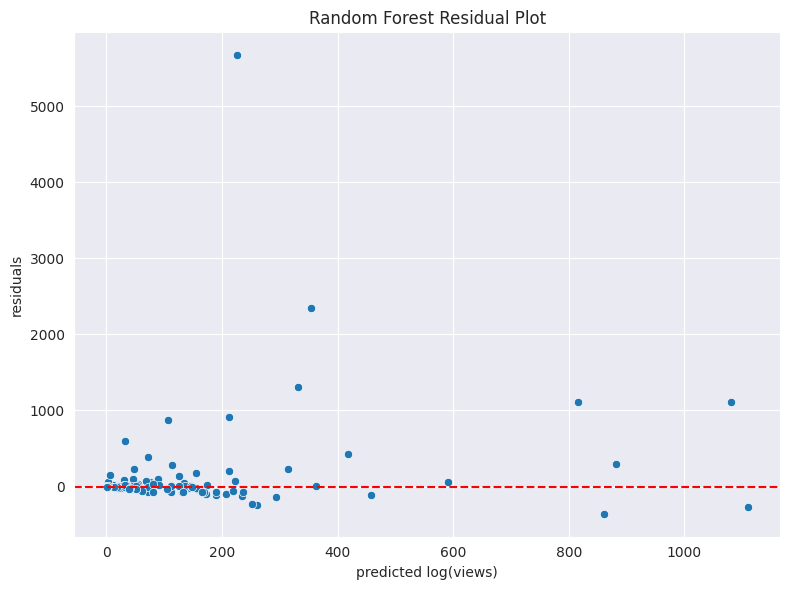

In [12]:
# visualize residuals to look for patterns
residuals = y_test_original - y_pred_original
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred_original, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted log(views)")
plt.ylabel("residuals")
plt.title("Random Forest Residual Plot")
plt.tight_layout()

# save png
# plt.savefig("images/rf_residual_plot.png", dpi=300)
plt.show()

In [13]:
# list top model feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)
top_features

log_channel_sub_count           0.616443
cbrt_published_duration_days    0.116306
log_channel_view_count          0.032597
log_channel_video_count         0.026089
log_duration_seconds            0.015481
term_outreach                   0.007985
term_vegan                      0.007893
cbrt_description_length         0.007778
title_length                    0.007136
term_animal                     0.006810
term_instagram                  0.005825
term_gains                      0.004896
hour_published                  0.004892
term_music                      0.004475
term_learn                      0.004425
month_published                 0.004298
weekday_published               0.004059
tag_count                       0.004003
term_subscribe                  0.003665
term_video                      0.003441
dtype: float64

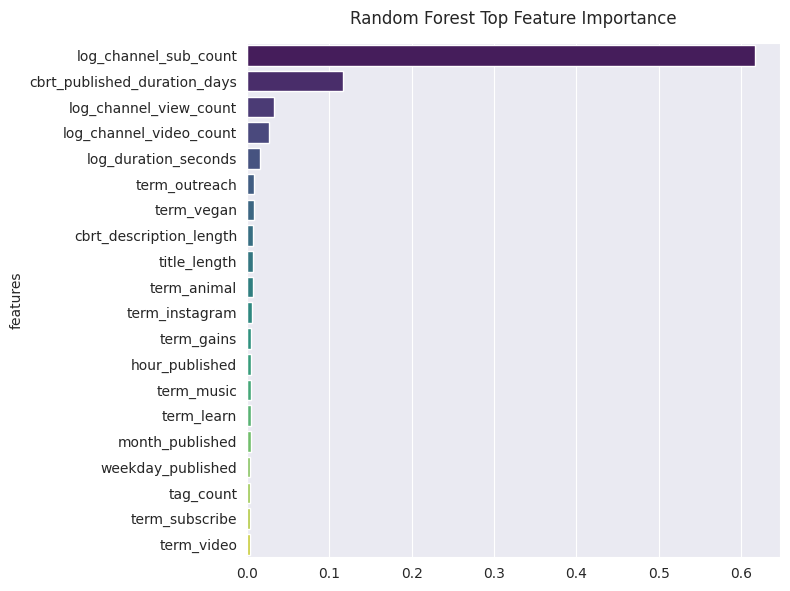

In [14]:
# visualize top 10 important features
plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("Random Forest Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/rf_top_feature_importance.png", dpi=300)
plt.show()

In [15]:
# instantiate xgboost and use randomized cross validation to search wide range of hyperparameters
params = {"xgbregressor__n_estimators": randint(500, 900), "xgbregressor__max_depth": randint(5, 20), "xgbregressor__learning_rate": uniform(0.01, 0.2),
          "xgbregressor__colsample_bytree": uniform(0.5, 0.5), "xgbregressor__gamma": uniform(0, 5), "xgbregressor__reg_alpha": uniform(0, 1), "xgbregressor__reg_lambda": uniform(0, 1)}

xgb_pipeline = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED))
xgb_rand_search = RandomizedSearchCV(xgb_pipeline, param_distributions=params, cv=10, n_iter=50, scoring="r2", n_jobs=-1, random_state=SEED)
xgb_rand_search.fit(X_train, y_train)
xgb_best_params = xgb_rand_search.best_params_
print(f"best score: {xgb_rand_search.best_score_}, best params: {xgb_best_params}")


best score: 0.7513621923360283, best params: {'xgbregressor__colsample_bytree': np.float64(0.6582470826836696), 'xgbregressor__gamma': np.float64(1.957414596350648), 'xgbregressor__learning_rate': np.float64(0.029787491735282313), 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 893, 'xgbregressor__reg_alpha': np.float64(0.47815103750119703), 'xgbregressor__reg_lambda': np.float64(0.9885036368931196)}


In [16]:
# use gridsearch for fine-tuning hyperparameters
params = {"xgbregressor__n_estimators": np.arange(xgb_best_params["xgbregressor__n_estimators"] - 10, xgb_best_params["xgbregressor__n_estimators"] + 15, 5),
          "xgbregressor__max_depth": np.arange(xgb_best_params["xgbregressor__max_depth"] - 4, xgb_best_params["xgbregressor__max_depth"] + 6, 2),
          "xgbregressor__learning_rate": [xgb_best_params["xgbregressor__learning_rate"]], "xgbregressor__colsample_bytree": [xgb_best_params["xgbregressor__colsample_bytree"]],
          "xgbregressor__gamma": [xgb_best_params["xgbregressor__gamma"]], "xgbregressor__reg_alpha": [xgb_best_params["xgbregressor__reg_alpha"]], "xgbregressor__lambda": [xgb_best_params["xgbregressor__reg_lambda"]]}

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_params = xgb_grid_search.best_params_
print(f"best score: {xgb_grid_search.best_score_}, best params: {xgb_best_params}")

best score: 0.7531460887352862, best params: {'xgbregressor__colsample_bytree': np.float64(0.6582470826836696), 'xgbregressor__gamma': np.float64(1.957414596350648), 'xgbregressor__lambda': np.float64(0.9885036368931196), 'xgbregressor__learning_rate': np.float64(0.029787491735282313), 'xgbregressor__max_depth': np.int64(4), 'xgbregressor__n_estimators': np.int64(883), 'xgbregressor__reg_alpha': np.float64(0.47815103750119703)}


In [17]:
# fit xgboost with optimal parameters
xgb_pipeline = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED, n_estimators=xgb_best_params["xgbregressor__n_estimators"],
                                                                max_depth=xgb_best_params["xgbregressor__max_depth"], learning_rate=xgb_best_params["xgbregressor__learning_rate"],
                                                                colsample_bytree=xgb_best_params["xgbregressor__colsample_bytree"], gamma=xgb_best_params["xgbregressor__gamma"],
                                                                reg_alpha=xgb_best_params["xgbregressor__reg_alpha"], reg_lambda=xgb_best_params["xgbregressor__lambda"]))
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
y_pred_original = inv_boxcox(y_pred, fitted_lambda)
box_rmse = root_mean_squared_error(y_test, y_pred)
original_rmse = root_mean_squared_error(y_test_original, y_pred_original)
medae = median_absolute_error(y_test_original, y_pred_original)
r2 = xgb_pipeline.score(X_test, y_test)
print(f"r2: {round(r2, 2)}, box_rmse: {round(box_rmse, 2)}, original_rmse: {round(original_rmse, 2)}, medae: {round(medae, 2)}")

r2: 0.81, box_rmse: 1.42, original_rmse: 506.58, medae: 13.71


In [18]:
# calculate 95% confidence intervals
r2_scores = []
rmse_scores = []
for i in range(1000):
    X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_train), replace=True, random_state=i)
    y_resampled_pred = xgb_pipeline.predict(X_resampled)
    y_resampled_original = inv_boxcox(y_resampled, fitted_lambda)
    y_resampled_pred_original = inv_boxcox(y_resampled_pred, fitted_lambda)
    rmse = root_mean_squared_error(y_resampled_original, y_resampled_pred_original)
    r2 = xgb_pipeline.score(X_resampled, y_resampled)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

r2_lower = np.percentile(r2_scores, 2.5)
r2_upper = np.percentile(r2_scores, 97.5)
rmse_lower = np.percentile(rmse_scores, 2.5)
rmse_upper = np.percentile(rmse_scores, 97.5)
print(f"R2 CI: [{round(r2_lower, 2)}, {round(r2_upper, 2)}], RMSE CI: [{round(rmse_lower, 2)}, {round(rmse_upper, 2)}]")

R2 CI: [0.79, 0.83], RMSE CI: [315.24, 669.33]


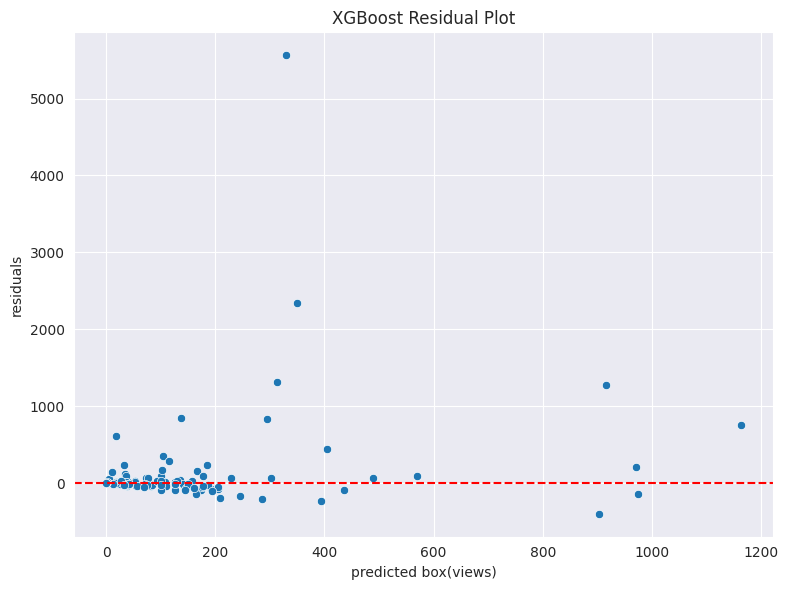

In [19]:
# visualize residuals to look for patterns
residuals = y_test_original - y_pred_original
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred_original, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted box(views)")
plt.ylabel("residuals")
plt.title("XGBoost Residual Plot")
plt.tight_layout()

# save png
plt.savefig("images/xgb_residual_plot.png", dpi=300)

In [20]:
# list top model feature importances
feature_importances = pd.Series(xgb_pipeline["xgbregressor"].feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)
top_features

log_channel_sub_count           0.095704
log_channel_view_count          0.055598
term_member                     0.036205
term_wayne                      0.034899
term_learn                      0.034290
term_visit                      0.027687
term_animal                     0.021911
term_music                      0.019675
term_uk                         0.018193
term_gains                      0.018162
term_outreach                   0.017767
term_vegangains                 0.015242
term_15                         0.014311
term_raw                        0.013496
cbrt_published_duration_days    0.013195
term_liberation                 0.011023
term_socials                    0.010883
term_hsiung                     0.010741
term_fi                         0.010492
cat_Education                   0.010424
dtype: float32

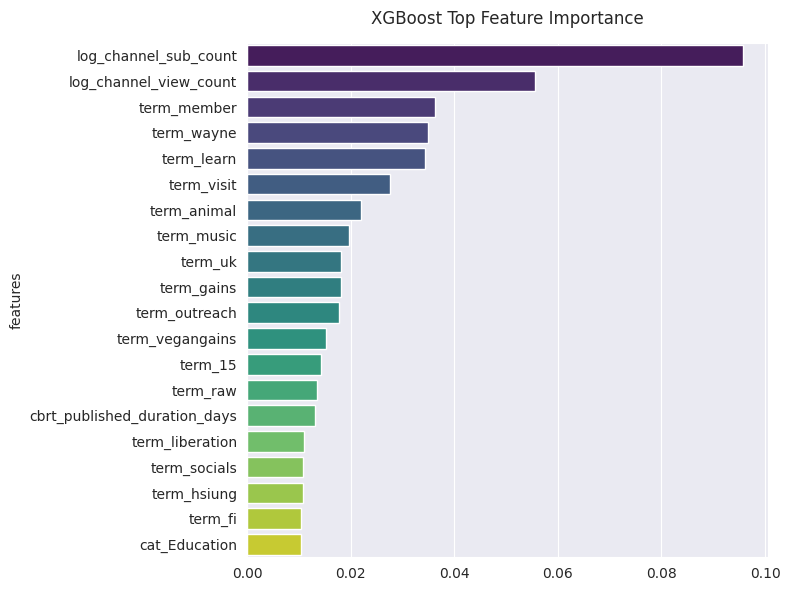

In [21]:
# visualize top 10 important features
plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("XGBoost Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/xgb_top_feature_importance.png", dpi=300)

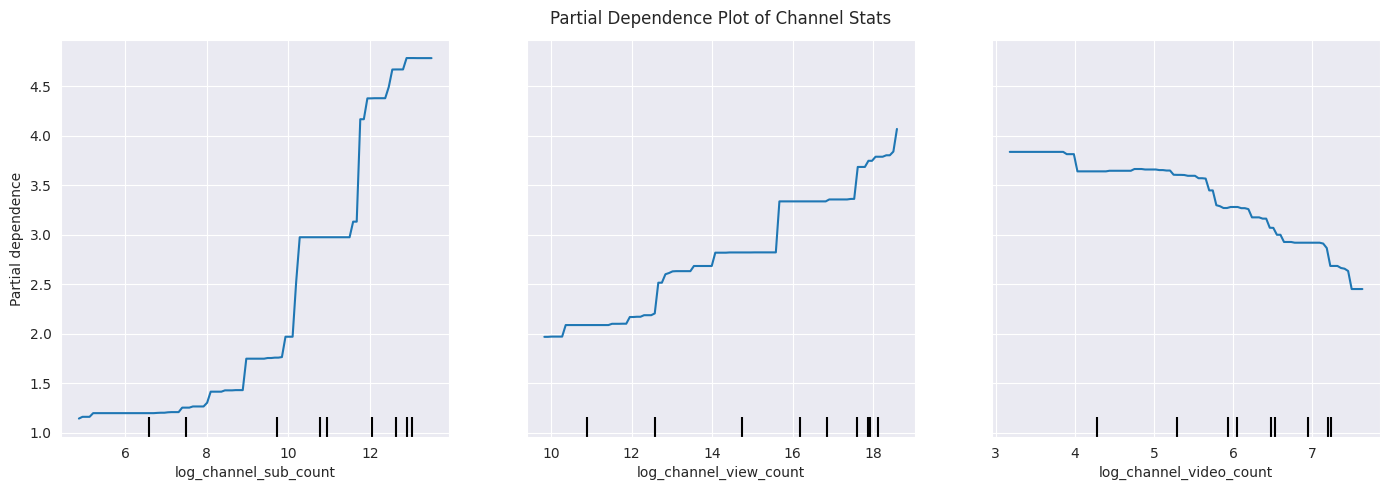

In [22]:
# visualize partial dependence for channel stats
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["log_channel_sub_count", "log_channel_view_count", "log_channel_video_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Channel Stats", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/pdp_channel_stats.png", dpi=300)

/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


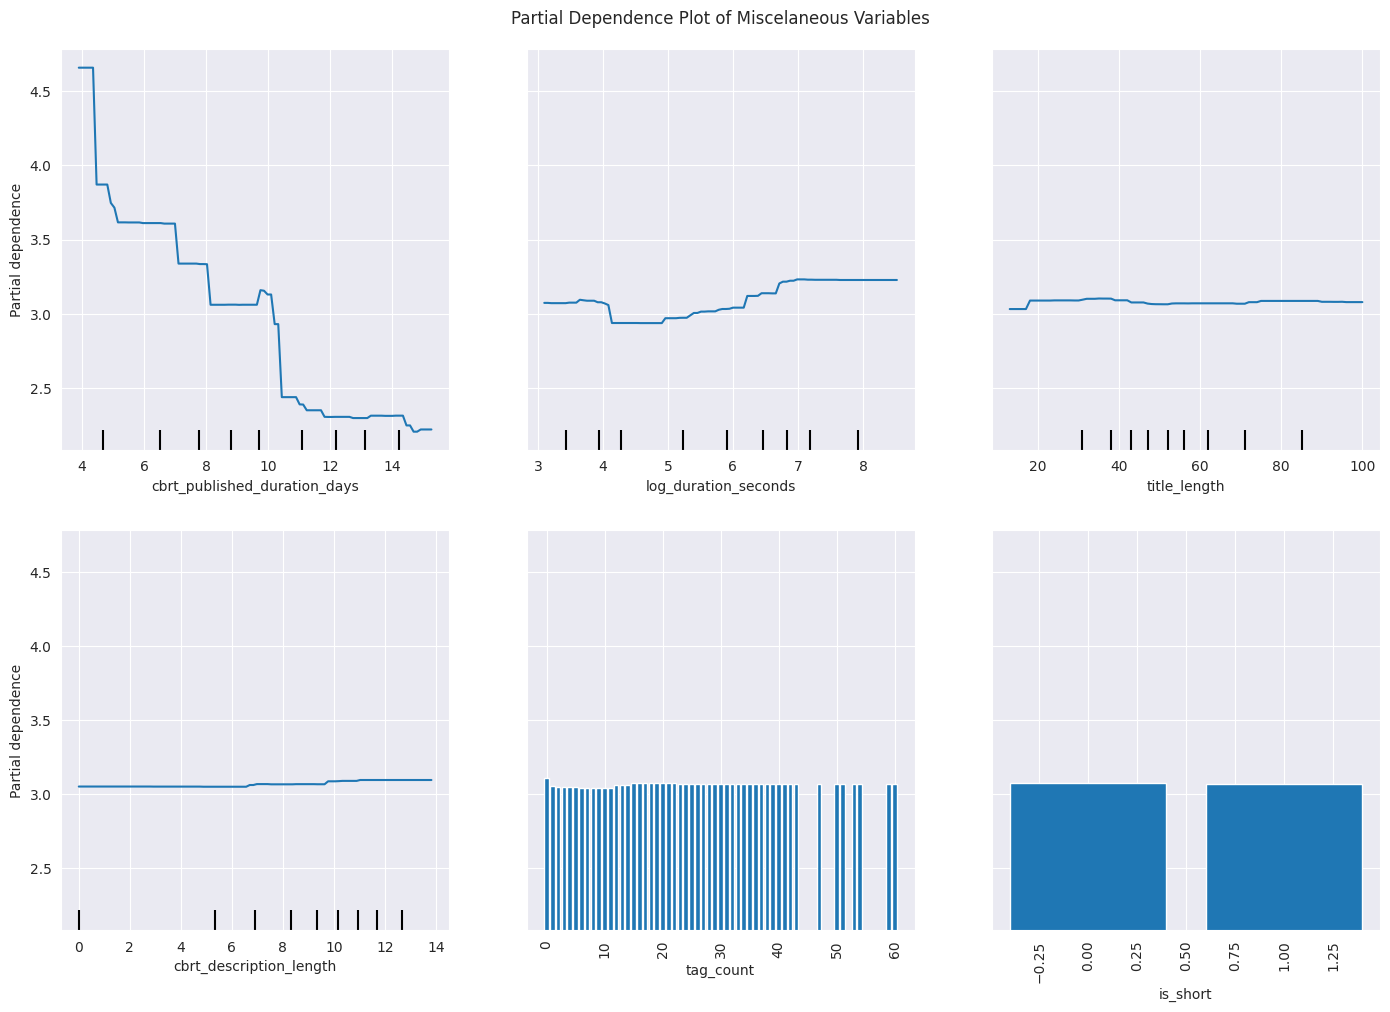

In [23]:
# visualize partial dependence for miscellaneous variables
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["cbrt_published_duration_days", "log_duration_seconds", "title_length", "cbrt_description_length", "tag_count", "is_short"], categorical_features=["tag_count", "is_short"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Miscelaneous Variables", y=1.02)
plt.tight_layout()

# save fig
plt.savefig("images/pdp_misc_variables.png", dpi=300)

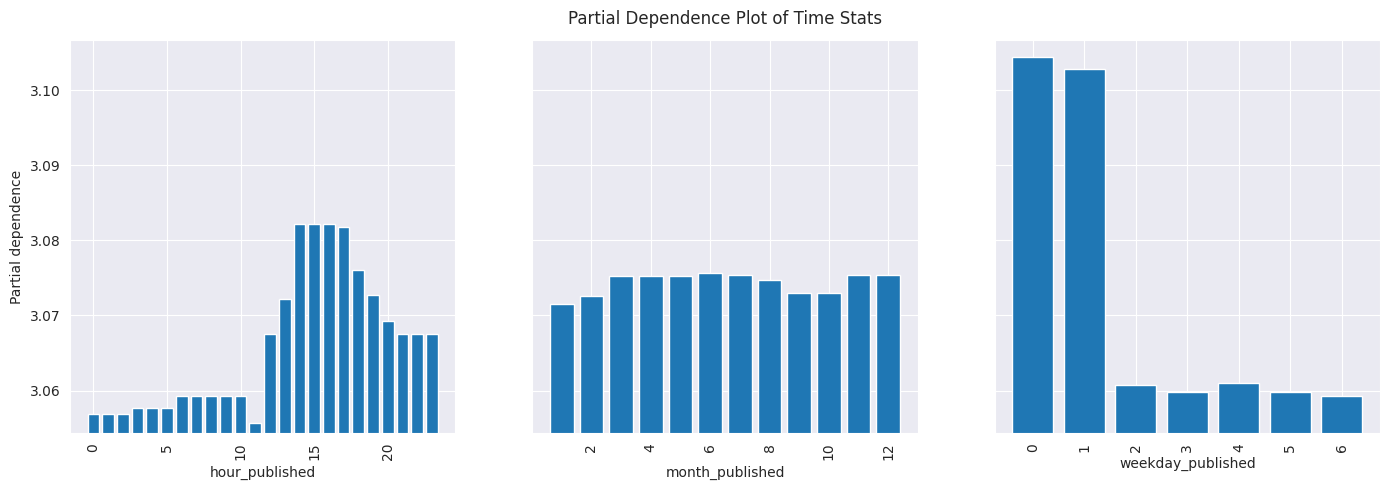

In [24]:
# visualize partial dependence time stats
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["hour_published", "month_published", "weekday_published"], categorical_features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Time Stats", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/pdp_time_stats.png", dpi=300)

In [25]:
# get the shap values of each feature
scaler = xgb_pipeline.named_steps["standardscaler"]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
explainer = shap.TreeExplainer(xgb_pipeline["xgbregressor"])
shap_values = pd.DataFrame(explainer.shap_values(X_train_scaled), columns=X_train.columns)
shap_values.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
0,-0.006175,-0.063421,0.026856,0.001487,-0.000561,0.005591,0.001534,-0.000041,0.000728,-0.000084,...,0.0,-0.000327,-0.000342,0.000571,0.001062,0.001665,-0.000064,0.0,0.0,0.0
1,-0.003376,0.002741,0.043223,-0.000554,-0.002793,0.011419,0.000689,-0.000028,0.002981,-0.000043,...,0.0,-0.000185,-0.000301,-0.043526,0.002241,-0.000746,-0.000064,0.0,0.0,0.0
2,0.077790,-0.001103,-0.010302,0.000899,0.003295,0.007771,-0.001093,-0.000041,0.001750,-0.000043,...,0.0,-0.000288,-0.000650,-0.019497,0.001909,-0.000605,-0.000064,0.0,0.0,0.0
3,-0.011088,0.004488,-0.014217,0.000267,-0.000145,0.010298,-0.000792,0.000043,0.000529,-0.000084,...,0.0,-0.000367,-0.000342,0.001274,0.021569,-0.000881,-0.000064,0.0,0.0,0.0
4,-0.003862,0.005299,-0.058209,-0.001721,-0.002793,0.006444,-0.000675,-0.000028,0.000807,-0.000084,...,0.0,-0.000367,-0.000409,0.001274,0.002175,0.002761,-0.000064,0.0,0.0,0.0


In [26]:
# list the top term features
terms = []
for col in feature_importances.index:
    if col.startswith("term_"):
        terms.append(col)
top_terms = terms[:20]
top_terms

['term_member',
 'term_wayne',
 'term_learn',
 'term_visit',
 'term_animal',
 'term_music',
 'term_uk',
 'term_gains',
 'term_outreach',
 'term_vegangains',
 'term_15',
 'term_raw',
 'term_liberation',
 'term_socials',
 'term_hsiung',
 'term_fi',
 'term_use',
 'term_subscribe',
 'term_diet',
 'term_youtu']

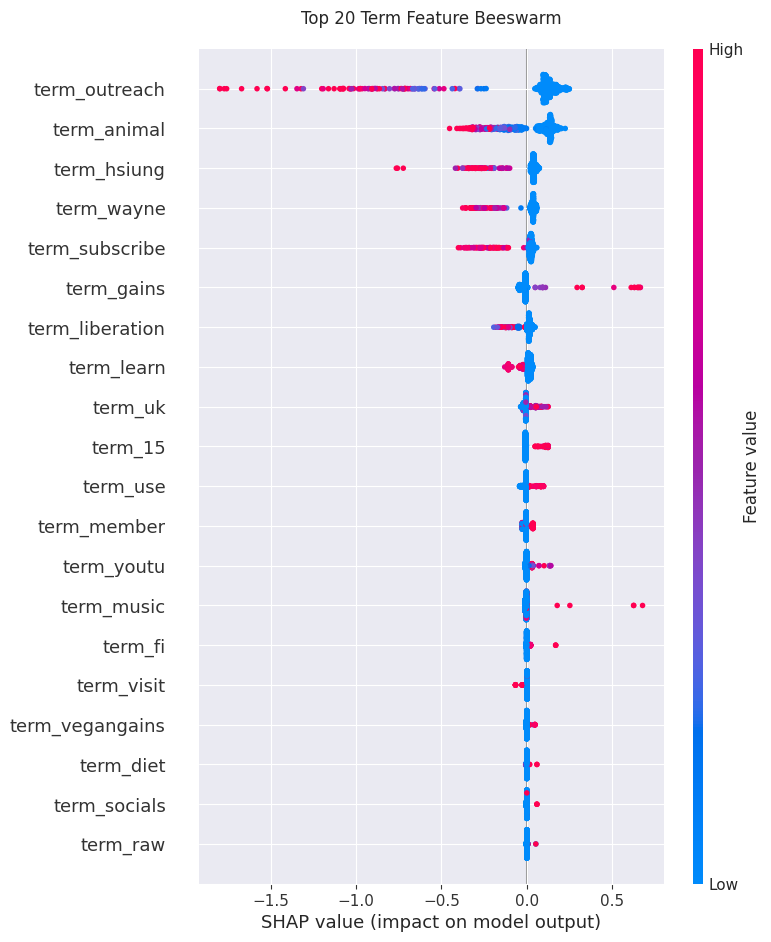

In [27]:
# visualize beeswarm of top 20 term features
plt.title("Top 20 Term Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[top_terms].values, X_train_scaled[top_terms], plot_type="dot", show=False)

# save png
plt.savefig("images/term_beeswarm.png", dpi=300)

In [28]:
# list the category features
categories = []
for col in feature_importances.index:
    if col.startswith("cat_"):
        categories.append(col)
categories

['cat_Education',
 'cat_Nonprofits & Activism',
 'cat_Howto & Style',
 'cat_Music',
 'cat_News & Politics',
 'cat_People & Blogs',
 'cat_Entertainment',
 'cat_Pets & Animals',
 'cat_Film & Animation',
 'cat_Gaming',
 'cat_Comedy',
 'cat_Science & Technology',
 'cat_Sports',
 'cat_Travel & Events']

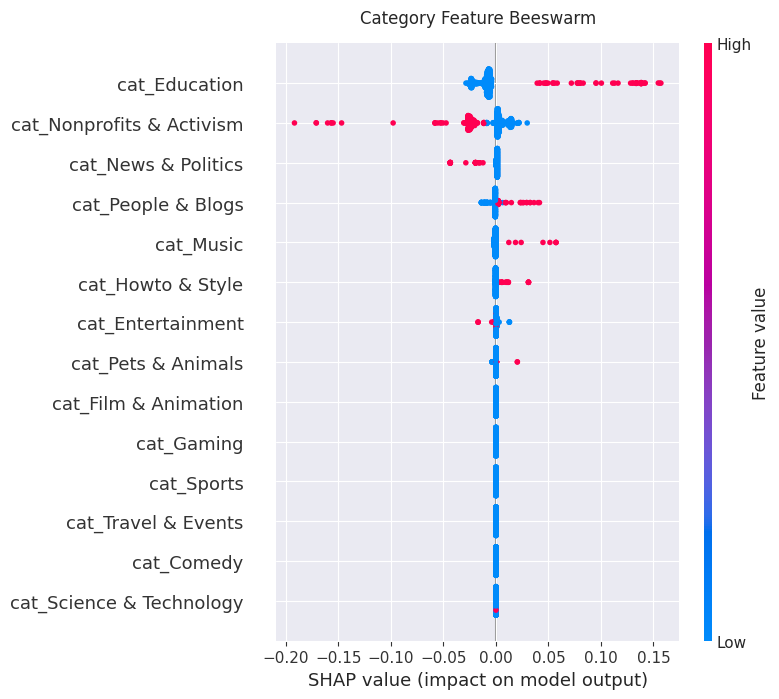

In [29]:
# visualize beeswarm of category features
plt.title("Category Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[categories].values, X_train_scaled[categories], plot_type="dot", show=False)
plt.tight_layout()

# save png
plt.savefig("images/category_beeswarm.png", dpi=300)

In [30]:
# save data and xgboost model
X_test.to_csv("data/x_test.csv", index=False)
residuals.to_csv("data/residuals.csv", index=False)
with open("data/xgb_pipeline.pkl", "wb") as f:
    pickle.dump(xgb_pipeline, f)